# Face Generation
In this project, we use generative adversarial networks (GANs) to generate new images of faces.
### Get the Data
Using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '~/data'
# note: use full path on computer (not just ~)
data_dir = '/home/thojo/work/ud/deep-learning/face_generation/data'

import helper
import pickle as pkl
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

In [2]:
# """
# DON'T MODIFY ANYTHING IN THIS CELL
# """


# helper.download_extract('mnist', data_dir)
# helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

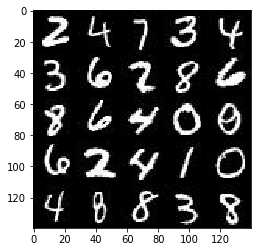

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

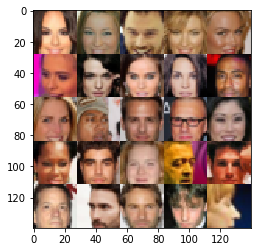

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/thojo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim ):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = 0.2, keep_prob = 0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # done: implement function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 28x28x1 for MNIST and celebA
            
            x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) 
            # no batch_normalization in the first layer
            lrelu1 = tf.maximum( alpha*x1, x1)
            lrelu1 = tf.nn.dropout(lrelu1, keep_prob)
            # now 14x14x64

            x2 = tf.layers.conv2d(lrelu1, 128, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn2 = tf.layers.batch_normalization( x2, training = True )
            lrelu2 = tf.maximum( alpha*bn2, bn2)
            lrelu2 = tf.nn.dropout(lrelu2, keep_prob)
            # now 7x7x128

            x3 = tf.layers.conv2d(lrelu1, 256, 5, strides = 2, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
            bn3 = tf.layers.batch_normalization( x3, training = True )
            lrelu3 = tf.maximum( alpha*bn3, bn3)
            lrelu3 = tf.nn.dropout(lrelu3, keep_prob)
            # now 4x4x256

            flat = tf.reshape( lrelu3,(-1,4*4*256) ) 
            logits = tf.layers.dense( flat, 1 )
            out = tf.sigmoid( logits )

            return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):   
        # Fully connected
        x1 = tf.layers.dense(z, 2*2*256, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape first layer as 2x2x256
        x1 = tf.reshape(x1, (-1, 2, 2, 256))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum( alpha*x1, x1) #leaky relu

        # Second layer as (7x7x128)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='VALID', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum( alpha*x2, x2) #leaky relu
        
        # Third layer as (14x14x64)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum( alpha*x3, x3) #leaky relu

        # Ouput layer as (28x28x out_channel_dim)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)

    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1 #For one-sided label smoothing (to prevent the discriminator from becoming too strong) 
    g_model = generator(input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real, reuse = False )
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True )

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(1-smooth)*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, controlling dependencies approporiately
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode, print_every=100, show_every=200):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1 )
 
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch_num = 0
        for epoch_i in range(epoch_count):
            # Train Model
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #rescaling to match the (-1,1) range of the tanh outputs from the generator
                steps += 1
                batch_num += 1
                # Sample random noise for G 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run( d_opt, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run( g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images, learning_rate: learning_rate_scalar })
                    train_loss_g = g_loss.eval({ input_z: batch_z, learning_rate: learning_rate_scalar})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch # {}/{}...".format(batch_num, epoch_i+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch # 100/1... Discriminator Loss: 1.2058... Generator Loss: 0.8972
Epoch 1/2... Batch # 200/1... Discriminator Loss: 1.2555... Generator Loss: 0.9309
Epoch 1/2... Batch # 300/1... Discriminator Loss: 1.1891... Generator Loss: 0.9686
Epoch 1/2... Batch # 400/1... Discriminator Loss: 1.1906... Generator Loss: 0.8885
Epoch 1/2... Batch # 500/1... Discriminator Loss: 1.2267... Generator Loss: 1.0701


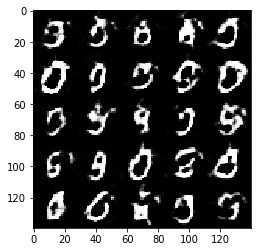

Epoch 1/2... Batch # 600/1... Discriminator Loss: 1.2501... Generator Loss: 0.8248
Epoch 1/2... Batch # 700/1... Discriminator Loss: 1.2864... Generator Loss: 0.8789
Epoch 1/2... Batch # 800/1... Discriminator Loss: 1.3318... Generator Loss: 0.7741
Epoch 1/2... Batch # 900/1... Discriminator Loss: 1.3249... Generator Loss: 0.9077
Epoch 1/2... Batch # 1000/1... Discriminator Loss: 1.2361... Generator Loss: 0.7356


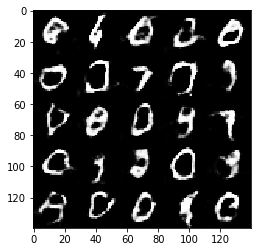

Epoch 1/2... Batch # 1100/1... Discriminator Loss: 1.2716... Generator Loss: 1.0939
Epoch 1/2... Batch # 1200/1... Discriminator Loss: 1.2918... Generator Loss: 0.9656
Epoch 1/2... Batch # 1300/1... Discriminator Loss: 1.2426... Generator Loss: 0.9685
Epoch 1/2... Batch # 1400/1... Discriminator Loss: 1.2947... Generator Loss: 0.8967
Epoch 1/2... Batch # 1500/1... Discriminator Loss: 1.2181... Generator Loss: 0.9954


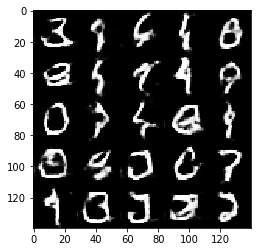

Epoch 1/2... Batch # 1600/1... Discriminator Loss: 1.2997... Generator Loss: 0.8711
Epoch 1/2... Batch # 1700/1... Discriminator Loss: 1.2361... Generator Loss: 0.9494
Epoch 1/2... Batch # 1800/1... Discriminator Loss: 1.3385... Generator Loss: 0.8535
Epoch 2/2... Batch # 1900/2... Discriminator Loss: 1.3857... Generator Loss: 0.8597
Epoch 2/2... Batch # 2000/2... Discriminator Loss: 1.2953... Generator Loss: 0.8112


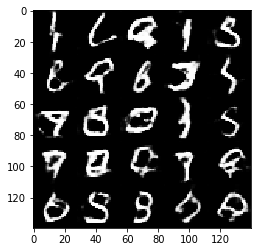

Epoch 2/2... Batch # 2100/2... Discriminator Loss: 1.2844... Generator Loss: 0.9706
Epoch 2/2... Batch # 2200/2... Discriminator Loss: 1.3351... Generator Loss: 0.9612
Epoch 2/2... Batch # 2300/2... Discriminator Loss: 1.2859... Generator Loss: 0.8592
Epoch 2/2... Batch # 2400/2... Discriminator Loss: 1.3369... Generator Loss: 1.1567
Epoch 2/2... Batch # 2500/2... Discriminator Loss: 1.2732... Generator Loss: 0.8189


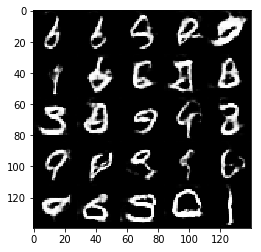

Epoch 2/2... Batch # 2600/2... Discriminator Loss: 1.3895... Generator Loss: 1.0883
Epoch 2/2... Batch # 2700/2... Discriminator Loss: 1.3153... Generator Loss: 0.8182
Epoch 2/2... Batch # 2800/2... Discriminator Loss: 1.2720... Generator Loss: 0.9645
Epoch 2/2... Batch # 2900/2... Discriminator Loss: 1.3283... Generator Loss: 0.7437
Epoch 2/2... Batch # 3000/2... Discriminator Loss: 1.2203... Generator Loss: 0.9508


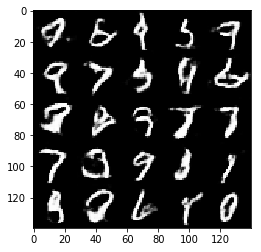

Epoch 2/2... Batch # 3100/2... Discriminator Loss: 1.3630... Generator Loss: 0.9295
Epoch 2/2... Batch # 3200/2... Discriminator Loss: 1.3243... Generator Loss: 0.9322
Epoch 2/2... Batch # 3300/2... Discriminator Loss: 1.2560... Generator Loss: 0.8358
Epoch 2/2... Batch # 3400/2... Discriminator Loss: 1.2682... Generator Loss: 0.9059
Epoch 2/2... Batch # 3500/2... Discriminator Loss: 1.2838... Generator Loss: 0.9104


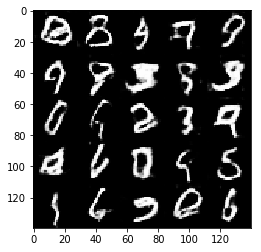

Epoch 2/2... Batch # 3600/2... Discriminator Loss: 1.2912... Generator Loss: 0.8565
Epoch 2/2... Batch # 3700/2... Discriminator Loss: 1.2771... Generator Loss: 1.0070


In [13]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0005
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, 
          mnist_dataset.image_mode, print_every, show_every)

__Project notes for MNIST:__ With batch_size of 32, we can use slightly larger learning rates (0.0005) and get d_loss of 1.17 with g_loss of 0.76.  Whereas with batches of 16 and a learning rate of 0.0003, we only get to d_loss of 1.2883 and g_loss of 0.97.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch # 100/1... Discriminator Loss: 1.0069... Generator Loss: 1.0337
Epoch 1/1... Batch # 200/1... Discriminator Loss: 0.8947... Generator Loss: 1.1448
Epoch 1/1... Batch # 300/1... Discriminator Loss: 0.7080... Generator Loss: 1.5271
Epoch 1/1... Batch # 400/1... Discriminator Loss: 0.5085... Generator Loss: 3.1300
Epoch 1/1... Batch # 500/1... Discriminator Loss: 0.5840... Generator Loss: 2.8508


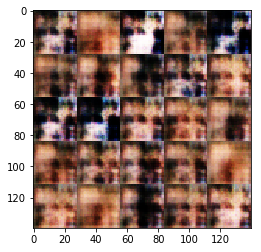

Epoch 1/1... Batch # 600/1... Discriminator Loss: 1.3726... Generator Loss: 0.9664
Epoch 1/1... Batch # 700/1... Discriminator Loss: 0.6390... Generator Loss: 1.9214
Epoch 1/1... Batch # 800/1... Discriminator Loss: 1.4032... Generator Loss: 0.9017
Epoch 1/1... Batch # 900/1... Discriminator Loss: 0.9009... Generator Loss: 1.1095
Epoch 1/1... Batch # 1000/1... Discriminator Loss: 0.9613... Generator Loss: 1.2738


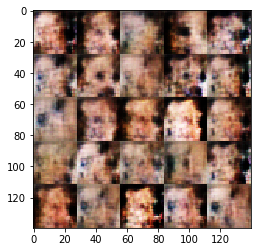

Epoch 1/1... Batch # 1100/1... Discriminator Loss: 0.7995... Generator Loss: 1.6236
Epoch 1/1... Batch # 1200/1... Discriminator Loss: 0.7636... Generator Loss: 1.7307
Epoch 1/1... Batch # 1300/1... Discriminator Loss: 1.4901... Generator Loss: 0.9247
Epoch 1/1... Batch # 1400/1... Discriminator Loss: 0.9848... Generator Loss: 1.4104
Epoch 1/1... Batch # 1500/1... Discriminator Loss: 0.9065... Generator Loss: 1.4809


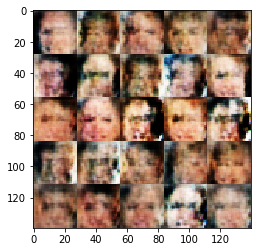

Epoch 1/1... Batch # 1600/1... Discriminator Loss: 1.3866... Generator Loss: 0.9934
Epoch 1/1... Batch # 1700/1... Discriminator Loss: 1.4799... Generator Loss: 0.8680
Epoch 1/1... Batch # 1800/1... Discriminator Loss: 1.5535... Generator Loss: 0.9274
Epoch 1/1... Batch # 1900/1... Discriminator Loss: 1.4227... Generator Loss: 0.9098
Epoch 1/1... Batch # 2000/1... Discriminator Loss: 1.5498... Generator Loss: 0.9372


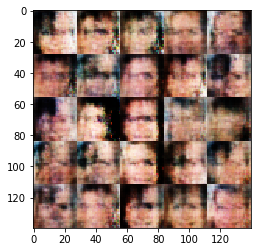

Epoch 1/1... Batch # 2100/1... Discriminator Loss: 1.4001... Generator Loss: 0.8899
Epoch 1/1... Batch # 2200/1... Discriminator Loss: 1.4415... Generator Loss: 0.8475
Epoch 1/1... Batch # 2300/1... Discriminator Loss: 1.4219... Generator Loss: 0.8264
Epoch 1/1... Batch # 2400/1... Discriminator Loss: 1.2998... Generator Loss: 0.9557
Epoch 1/1... Batch # 2500/1... Discriminator Loss: 1.1628... Generator Loss: 0.9638


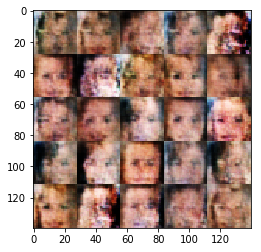

Epoch 1/1... Batch # 2600/1... Discriminator Loss: 1.1582... Generator Loss: 0.9368
Epoch 1/1... Batch # 2700/1... Discriminator Loss: 1.1320... Generator Loss: 0.9967
Epoch 1/1... Batch # 2800/1... Discriminator Loss: 1.0728... Generator Loss: 0.9682
Epoch 1/1... Batch # 2900/1... Discriminator Loss: 1.4779... Generator Loss: 0.8698
Epoch 1/1... Batch # 3000/1... Discriminator Loss: 1.4712... Generator Loss: 0.8743


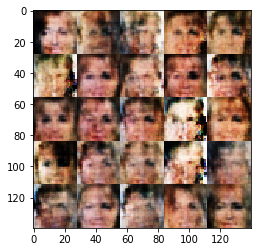

Epoch 1/1... Batch # 3100/1... Discriminator Loss: 1.4453... Generator Loss: 0.8608
Epoch 1/1... Batch # 3200/1... Discriminator Loss: 1.4344... Generator Loss: 0.8027
Epoch 1/1... Batch # 3300/1... Discriminator Loss: 1.3673... Generator Loss: 0.7783
Epoch 1/1... Batch # 3400/1... Discriminator Loss: 1.4162... Generator Loss: 0.8531
Epoch 1/1... Batch # 3500/1... Discriminator Loss: 1.3532... Generator Loss: 0.8912


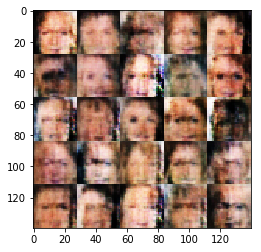

Epoch 1/1... Batch # 3600/1... Discriminator Loss: 1.3815... Generator Loss: 0.8071
Epoch 1/1... Batch # 3700/1... Discriminator Loss: 1.2127... Generator Loss: 0.9333
Epoch 1/1... Batch # 3800/1... Discriminator Loss: 1.1860... Generator Loss: 1.0496
Epoch 1/1... Batch # 3900/1... Discriminator Loss: 1.1730... Generator Loss: 0.9458
Epoch 1/1... Batch # 4000/1... Discriminator Loss: 1.4034... Generator Loss: 0.8518


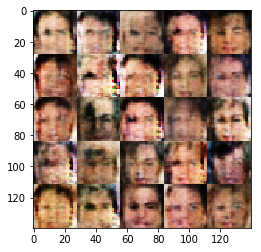

Epoch 1/1... Batch # 4100/1... Discriminator Loss: 1.3810... Generator Loss: 0.8053
Epoch 1/1... Batch # 4200/1... Discriminator Loss: 1.4001... Generator Loss: 0.8633
Epoch 1/1... Batch # 4300/1... Discriminator Loss: 1.1327... Generator Loss: 1.0032
Epoch 1/1... Batch # 4400/1... Discriminator Loss: 1.1951... Generator Loss: 0.9951
Epoch 1/1... Batch # 4500/1... Discriminator Loss: 1.4019... Generator Loss: 0.8669


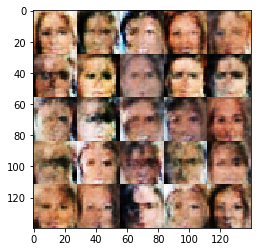

Epoch 1/1... Batch # 4600/1... Discriminator Loss: 1.3730... Generator Loss: 0.8478
Epoch 1/1... Batch # 4700/1... Discriminator Loss: 1.1980... Generator Loss: 0.9862
Epoch 1/1... Batch # 4800/1... Discriminator Loss: 1.1819... Generator Loss: 0.8903
Epoch 1/1... Batch # 4900/1... Discriminator Loss: 1.3861... Generator Loss: 0.9484
Epoch 1/1... Batch # 5000/1... Discriminator Loss: 1.4255... Generator Loss: 0.8912


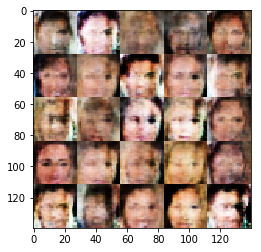

Epoch 1/1... Batch # 5100/1... Discriminator Loss: 1.3767... Generator Loss: 0.8466
Epoch 1/1... Batch # 5200/1... Discriminator Loss: 1.3933... Generator Loss: 0.7835
Epoch 1/1... Batch # 5300/1... Discriminator Loss: 1.2459... Generator Loss: 0.9017
Epoch 1/1... Batch # 5400/1... Discriminator Loss: 1.2677... Generator Loss: 0.8605
Epoch 1/1... Batch # 5500/1... Discriminator Loss: 1.2166... Generator Loss: 0.9434


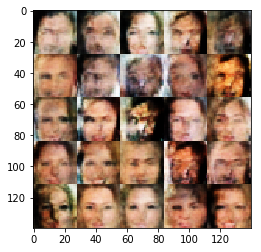

Epoch 1/1... Batch # 5600/1... Discriminator Loss: 1.4238... Generator Loss: 0.7867
Epoch 1/1... Batch # 5700/1... Discriminator Loss: 1.3821... Generator Loss: 0.8773
Epoch 1/1... Batch # 5800/1... Discriminator Loss: 1.3932... Generator Loss: 0.8689
Epoch 1/1... Batch # 5900/1... Discriminator Loss: 1.3791... Generator Loss: 0.7718
Epoch 1/1... Batch # 6000/1... Discriminator Loss: 1.3722... Generator Loss: 0.7997


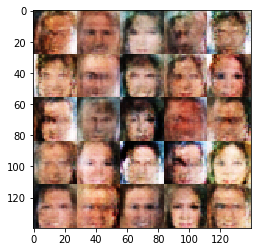

Epoch 1/1... Batch # 6100/1... Discriminator Loss: 1.2626... Generator Loss: 0.9035
Epoch 1/1... Batch # 6200/1... Discriminator Loss: 1.2907... Generator Loss: 0.8675
Epoch 1/1... Batch # 6300/1... Discriminator Loss: 1.1725... Generator Loss: 1.0696


In [14]:
batch_size = 32 #needs to be a factor of 4096
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2

print_every = 100
show_every = 500
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, print_every, show_every)

__Project notes:__ 

I have tried batch sizes of 16, 32, 64 and 128.  For smaller batches, the learning rate needs to be smaller too (as the gradients are more likely to go unstable).  Thanks to my reviewer for suggesting going as low as 16!

For learning rates, I went from 0.0002 to 0.0008.  Batch size 32 with a learning rate of 0.0005 seems to perform well for MNIST. However, for celebA, a smaller batch size (16), a smaller learning rate (0.0003) produces better images. d_loss was 1.34 and g_loss is 0.80.

Tried dropout.  For celebA, with batch_size = 16, lr=0.0002, dropout with keep_prob = 0.5 resulted in OK faces with d_loss=1.31 and g_loss =1.18. With keep_prob of 0.8, and a higher lr of 0.0003, we get to d_loss=1.35 and g_loss =0.80

I have also run this upto 50 epochs on AWS and that gave sharper and better outputs.  This is from the roughly 1 GB GPU that I have on my local machine.  For the project, we're looking at performance with just 1 epoch.  

Faces are recognizable in a single epoch.  I have tried beta1 values of 0.9, 0.5 and also lower values. 0.2 is good, as is 0.3.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.